# Krypton 2LT

## Study the hipothesis of two lifetimes in detector

### Author: JJGC

In [1]:
import time
print("Last updated on ", time.asctime())

Last updated on  Mon Aug 20 22:11:36 2018


### Input files

In [2]:
input_path  = f"$IC_DATA/dst"
output_path = f"$IC_DATA/ldst"
map_path    = f"$IC_DATA/maps"

input_file_names  = ['dst_6206_0000_9999.h5','dst_6206_10000_19999.h5',
                    'dst_6206_20000_29999.h5','dst_6206_30000_39299.h5']
output_file_name  = 'ldst_6206.h5'
map_file_name     = 'kr_corrections_6206.h5'
bootstrap_correction_filename   = f"$IC_DATA/maps/kr_corrections_run6206.h5"

### Notebook configuration

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

In [4]:
import os
import time
import datetime 
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings

In [5]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units

In [6]:
from krcal.core          import fit_functions_ic as fitf

In [8]:
from krcal.core.io_functions       import kdst_write
from krcal.core.io_functions       import filenames_from_list

In [9]:
from krcal.core.histo_functions    import h1, h1d, h2, h2d, plot_histo
from krcal.core.plt_functions           import plot_xy_density

In [10]:
from krcal.core.core_functions          import time_delta_from_time
from krcal.core.analysis_functions      import kr_ranges_and_bins
from krcal.core.analysis_functions      import fiducial_volumes
from krcal.core.analysis_functions      import fid_eff
from krcal.core.analysis_functions      import kr_event_selection

In [11]:
from krcal.core.fit_lt_functions        import fit_lifetime
from krcal.core.fit_lt_functions        import lt_lifetime
from krcal.core.fit_lt_functions        import plot_fit_lifetime_and_chi2
from krcal.core.fit_lt_functions        import print_fit_lifetime
from krcal.core.fit_lt_functions        import time_fcs
from krcal.core.fit_lt_functions        import fb_fits

In [17]:
from krcal.core.fit_lt_histograms       import histo_fit_fb_pars
from krcal.core.fit_lt_histograms          import plot_fit_fb_pars
from krcal.core.fit_lt_histograms          import print_fit_fb_pars
from krcal.core.fit_lt_histograms          import histo_fit_sectors
from krcal.core.fit_lt_histograms          import print_fit_sectors_pars
from krcal.core.fit_lt_histograms          import plot_fit_sectors

In [18]:
from krcal.core.kr_types import PlotLabels, KrEvent
from krcal.core.kr_types import FitType, KrSector, MapType


In [19]:
import krcal.dev.corrections       as corrections 


In [20]:
from numpy import pi

In [21]:
from typing      import List, Tuple, Dict, Sequence, Iterable

In [22]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display

### Input/output 

In [23]:
input_dst_filenames, output_dst_filename, map_filename =filenames_from_list(input_file_names,
                                                                            output_file_name,
                                                                            map_file_name,
                                                                            input_path,
                                                                            output_path,
                                                                            map_path)

In [24]:
print(f'input dsts:\n first = {input_dst_filenames[0]}\n last = {input_dst_filenames[-1]}')
print(f"output dst = {output_dst_filename}")
print(f"map file   = {map_filename}")

input dsts:
 first = /Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_0000_9999.h5
 last = /Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_30000_39299.h5
output dst = /Users/jjgomezcadenas/Projects/ICDATA/ldst/ldst_6206.h5
map file   = /Users/jjgomezcadenas/Projects/ICDATA/maps/kr_corrections_6206.h5


In [25]:
dst           = load_dsts(input_dst_filenames, "DST", "Events")

In [26]:
unique_events = ~dst.event.duplicated()
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of events: {number_of_evts_full}")

Total number of events: 4085430


In [27]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Time differences in seconds

In [28]:
dst_time = dst.sort_values('event')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

### Ranges and binning

In [29]:
s1e_range = (2, 30)
s2e_range = (2000, 14000)
s2q_range = (200, 800)
xy_range  = (-220,  220)
z_range   = (10,  550)
krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 100,
                                                        ynbins    = 100,
                                                        znbins    = 12,
                                                        s2enbins  = 50,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

### Corrected S2e and Q

In [30]:
bootstrap_correction_filename = os.path.expandvars(bootstrap_correction_filename)
calibrate = corrections.Calibration(bootstrap_correction_filename)
E, Q = calibrate(dst.X, dst.Y, None, dst.time, dst.S2e, dst.S2q)

calibration file : /Users/jjgomezcadenas/Projects/ICDATA/maps/kr_corrections_run6206.h5
node             : geometry
Energy   scale :  1.0 (pes)
Lifetime scale : 2324.4 (us) 
Charge   scale :  1.0 (pes)


### This defines 4 concentric rings as chamber sectors 

In [31]:
sfull  =  KrSector(rmin = 0, rmax = 200, phimin=0, phimax=360)
sfid   =  KrSector(rmin = 0, rmax = 150, phimin=0, phimax=360)
score  =  KrSector(rmin = 0, rmax = 100, phimin=0, phimax=360)
shcore =  KrSector(rmin = 0, rmax = 50,  phimin=0, phimax=360)

In [32]:
krf = fiducial_volumes(dst, DT, E, Q, sectors=(sfull, sfid, score, shcore))

In [33]:
kfull, kfid, kcore, khcore = krf[0], krf[1], krf[2], krf[3]

In [34]:
print(f' full: eff = {fid_eff(dst, kfull)}')
print(f' fid: eff = {fid_eff(dst, kfid)}')
print(f' core: eff = {fid_eff(dst, kcore)}')
print(f' hcore: eff = {fid_eff(dst, khcore)}')

 full: eff = 0.9977380593964406
 fid: eff = 0.5955855320003035
 core: eff = 0.26191441292593437
 hcore: eff = 0.06515593217849773


### Time 

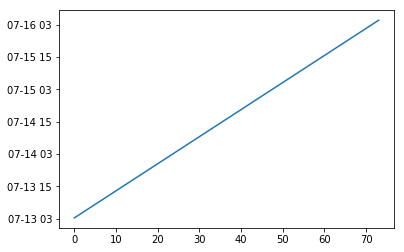

In [35]:
plt.plot(krTimes.timeStamps)

### Event distribution

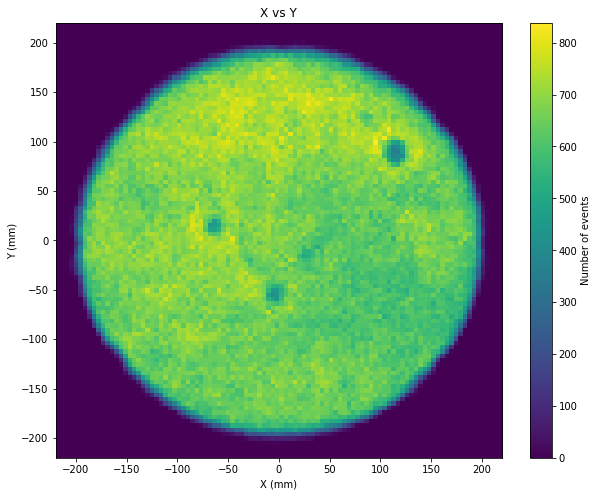

In [36]:
nevt = h2d(dst.X, dst.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y'),
           profile=False,
           figsize=(10,8))

## Lifetime

#### Lifetime may depend:
- on XY position (even more generally on XYZ) due to inhomogenous distributions of impurities (flux related)
- On t (lifetime varies with time).

-Lifetime is determined by dividing the chamber in sectors (R, Rphi) or (X,Y) and fitting an exponential to the energy distribution as a function of Z. The fit yields the lifetime and the value of energy (at z=0) in that sector. 

-The fit must yield a good chi2 (~1). A bad chi2 may signal a variation in the lifetime as a function of (r,phi, t).

#### Example: Fit lifetime in hard core sector (0 < R < 50, -pi < Phi < phi) and in the full time range

In [37]:
fc = fit_lifetime(khcore.Z, khcore.S2e, 
                  nbins_z=krNbins.Z, nbins_e=krNbins.S2e, 
                  range_z=(100,550), range_e=(8000, 12000),
                  fit = FitType.profile)


 Ez0     = 11742.848905698535 +-1.4364315355913955 
 LT      = 2598.330182079628 +-2.5007467686635336 
 chi2    = 3.5579844081517216 


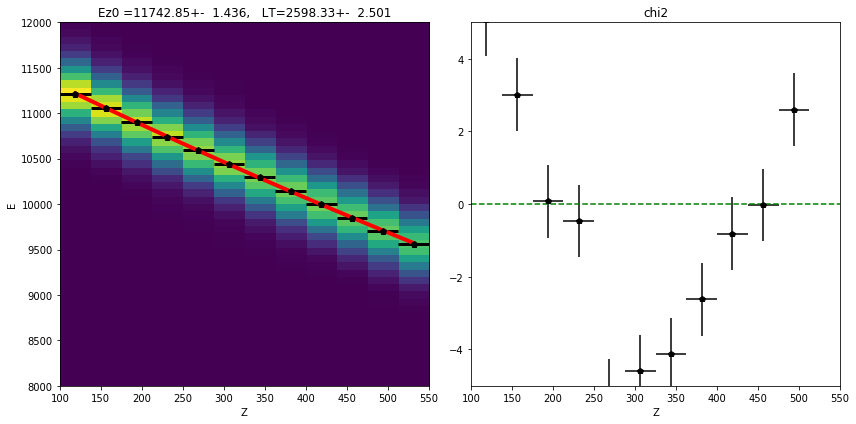

In [38]:
plot_fit_lifetime_and_chi2(fc, figsize=(12,6))
print_fit_lifetime(fc)

#### chi2 value is too high, indicating that lifetime is changing across the span of the fit. The most obvious reason for such a change is a dependence on t

#### Repeat fit using geometry-corrected energy E (should be pretty similar to hcore)

 Ez0     = 10074.505299722963 +-1.0367036513726826 
 LT      = 2594.6393949447324 +-2.17084437147555 
 chi2    = 3.3946266614954475 


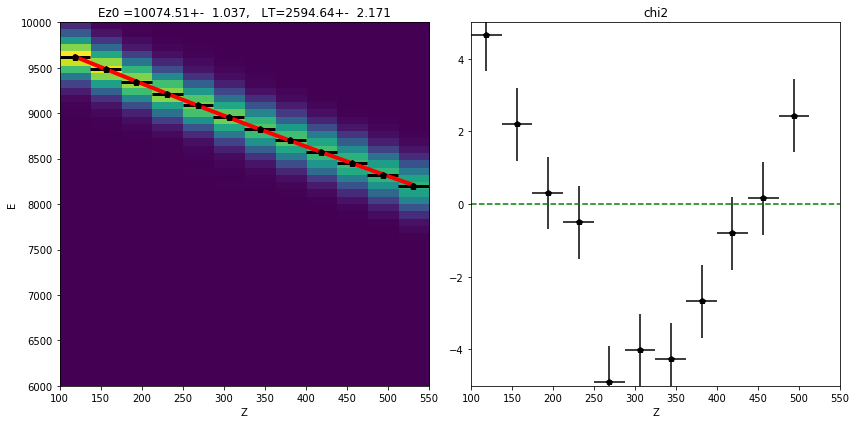

In [39]:
fc = fit_lifetime(khcore.Z, khcore.E, fit = FitType.profile, 
                  nbins_z=krNbins.Z, nbins_e=krNbins.S2e, 
                  range_z=(100,550), range_e=(6000, 10000))
plot_fit_lifetime_and_chi2(fc, figsize=(12,6))
print_fit_lifetime(fc)

### Select in time

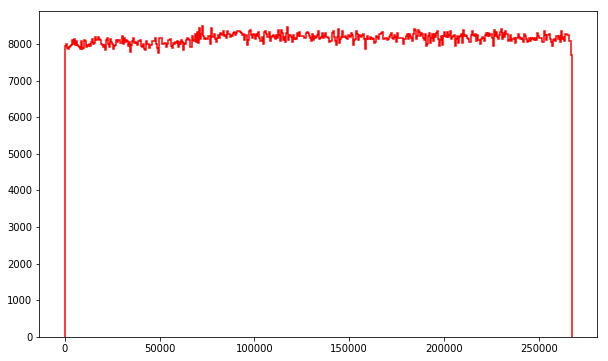

In [40]:
fig           = plt.figure(figsize=(10,6))
ax            = fig.add_subplot(1, 1, 1)
n, b, _, _    = h1(kfull.DT, bins=500, range = (kfull.DT[0], kfull.DT[-1]), 
                   color='red', stats=False, lbl='time evolution')

### Consider time slices

In [41]:
sel_mask = in_range(khcore.DT, 0, 5e+3)

In [42]:
kct0 =kr_event_selection(khcore,sel_mask)

#### Fit to S2e in the first 5,000 seconds

 Ez0     = 11735.54440281 +-10.501134428089227 
 LT      = 2522.0241964172033 +-17.190018682684922 
 chi2    = 0.9863669321570722 


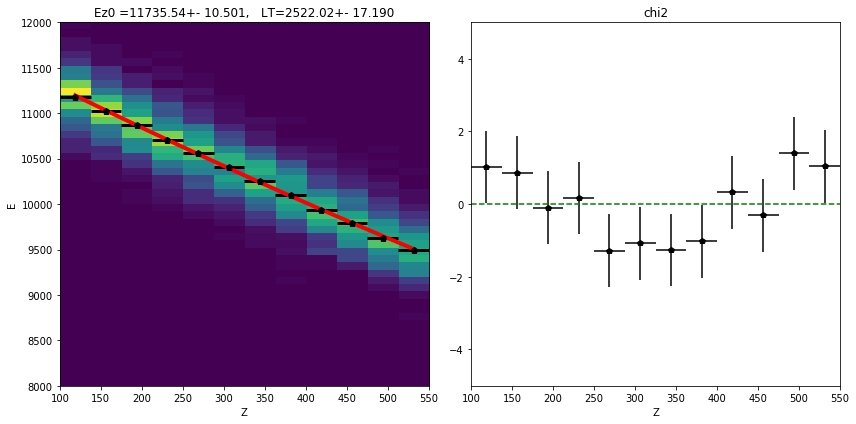

In [43]:
fc = fit_lifetime(kct0.Z, kct0.S2e, fit = FitType.profile, 
                  nbins_z=krNbins.Z, nbins_e=krNbins.S2e, 
                  range_z=(100,550), range_e=(8000, 12000))
plot_fit_lifetime_and_chi2(fc, figsize=(12,6))
print_fit_lifetime(fc)

#### The fit yields good chi2, showing that in hcore and first 5,000 seconds lifetime can be described as a single number for all the chamber

#### Fit to the corrected energy E

 Ez0     = 10076.675095213403 +-7.504559102759094 
 LT      = 2503.370355686178 +-14.51596836744424 
 chi2    = 1.2931844760032576 


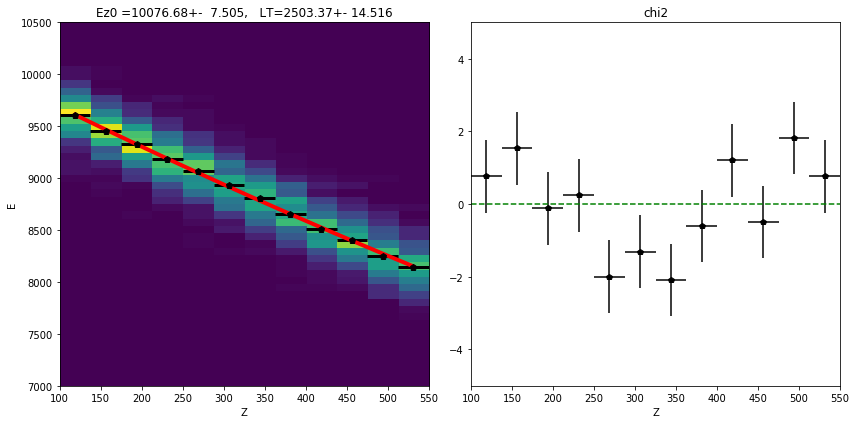

In [44]:
fc = fit_lifetime(kct0.Z, kct0.E, fit = FitType.profile, 
                  nbins_z=krNbins.Z, nbins_e=krNbins.S2e, 
                  range_z=(100,550), range_e=(7000, 10500))
plot_fit_lifetime_and_chi2(fc, figsize=(12,6))
print_fit_lifetime(fc)

#### The chi2 is not as good as S2e, showing a posible bias in the geometrical factors used to correct the energy. 

### Can the data (in time series) be described better by two exponentials fit than by one exponential?

In [45]:
XT = 5000 # time bins

### hard core

#### S2e

In [54]:
fp, fpf, fpb = fb_fits(XT, DT, khcore, krNbins.Z, krNbins.S2e, 
                       range_z=(50,550), 
                       range_zf=(50,300), 
                       range_zb=(300,550), 
                       range_e = (7000, 12000),
                       energy = 'S2e', fit = FitType.profile)



chi2:  full  =     1.02  +-   0.24; front =     0.92 +-   0.23; back  =     0.92 +-   0.19;
e0  :  full  = 11738.00  +-  10.25; front = 11726.50 +-  15.32; back  = 11785.44 +-  37.40;
lt  :  full  =  2606.91  +-  50.59; front =  2649.36 +-  72.05; back  =  2543.55 +-  66.32;


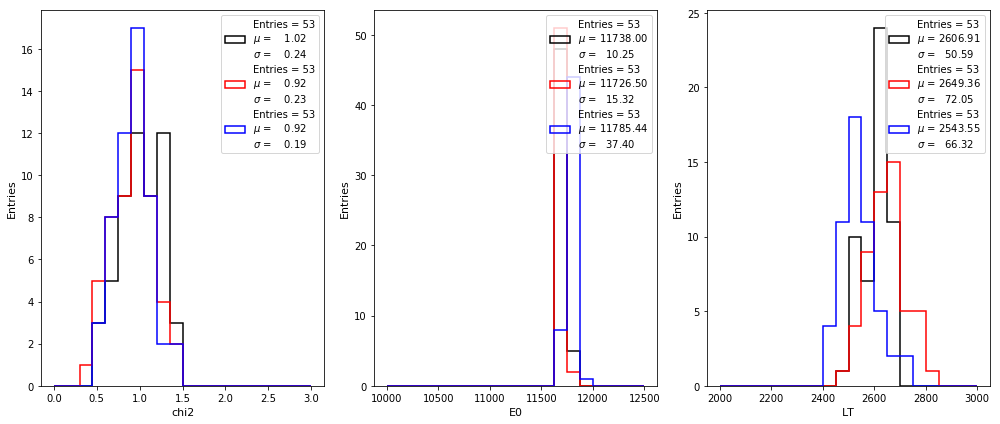

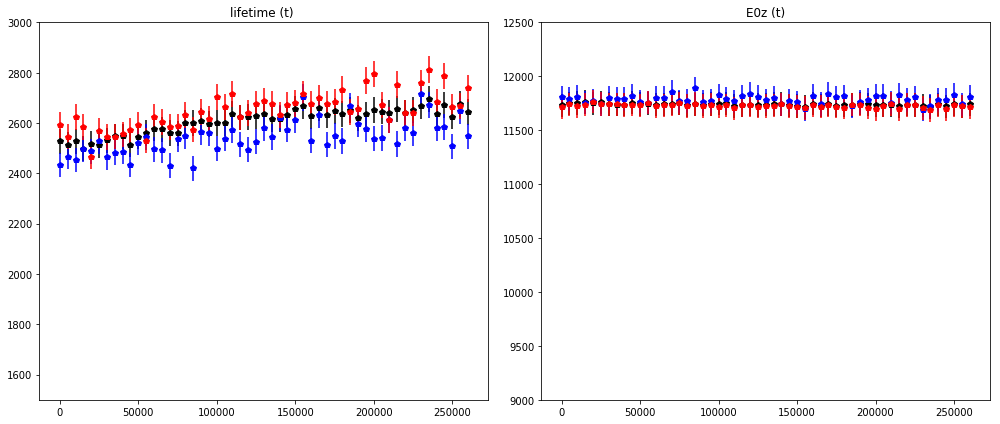

In [62]:
fbp = histo_fit_fb_pars(fp, fpf, fpb)
plot_fit_fb_pars (fp, fpf, fpb)
print_fit_fb_pars(fbp)

#### Fits in hcore: S2e
The fit to a single exponential has good chi2 (~1), and averages the fits in forward and backward part of the chamber. The apparent difference in lifetime forward/backward is anticorrelated with a change in E0. **The data in this region does not support two exponentials rather than one**. 

#### E

In [63]:
fp, fpf, fpb = fb_fits(XT, DT, khcore, krNbins.Z, krNbins.S2e, 
                       range_z=(50,550), 
                       range_zf=(50,300), 
                       range_zb=(300,550), 
                       range_e = (7000, 12000),
                       energy = 'E', fit = FitType.profile)

chi2:  full  =     1.05  +-   0.25; front =     0.86 +-   0.19; back  =     0.92 +-   0.21;
e0  :  full  = 10070.21  +-   8.15; front = 10063.68 +-  11.04; back  = 10107.91 +-  30.14;
lt  :  full  =  2603.64  +-  49.83; front =  2633.93 +-  59.82; back  =  2544.33 +-  63.51;


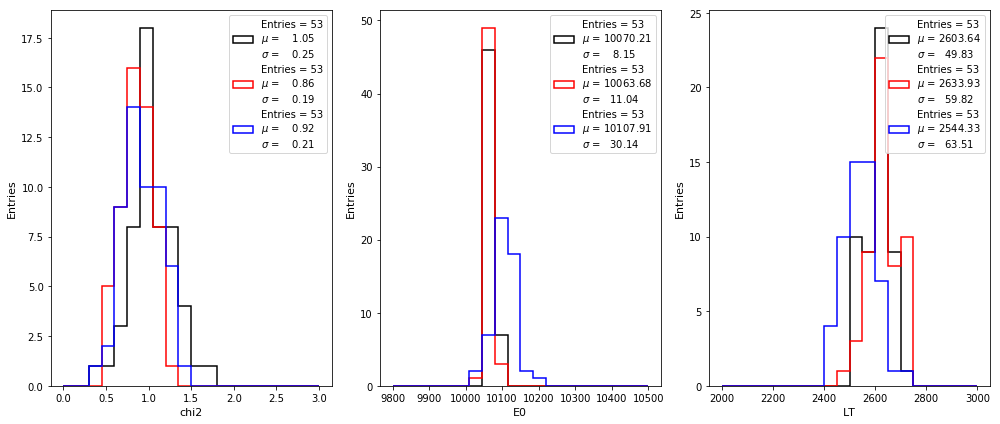

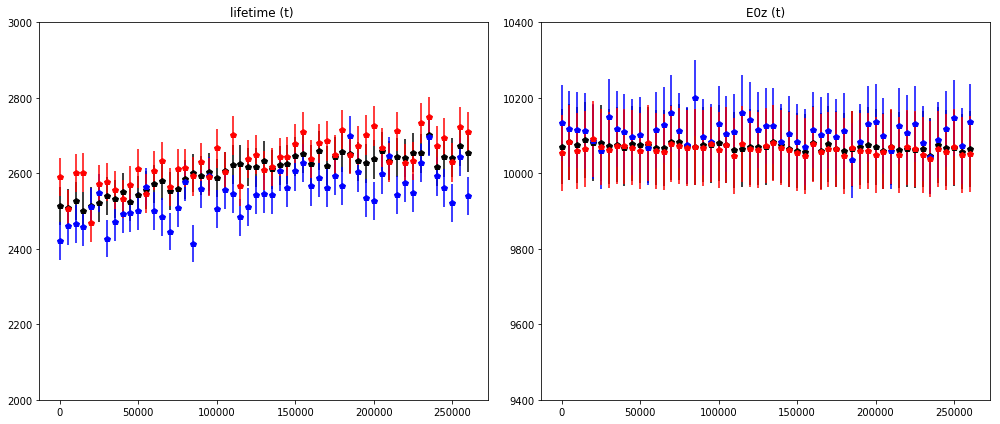

In [64]:
fbp = histo_fit_fb_pars(fp, fpf, fpb, range_e0 =(9800,10500))
plot_fit_fb_pars (fp, fpf, fpb,ltlim=(2000,3000), e0lim=(9400,10400))
print_fit_fb_pars(fbp)


#### Fits in hcore: E
**Same results than fits with S2e**. Lifetime values compatible. Different E0 value is due to overall normalization and expected. 

### Core

#### S2e

In [65]:
fp, fpf, fpb = fb_fits(XT, DT, kcore, krNbins.Z, krNbins.S2e, 
                       range_z=(50,550), 
                       range_zf=(50,300), 
                       range_zb=(300,550), 
                       range_e = (7000, 12000),
                       energy = 'S2e', fit = FitType.profile)

chi2:  full  =     1.07  +-   0.23; front =     0.93 +-   0.22; back  =     0.88 +-   0.20;
e0  :  full  = 11492.50  +-   7.36; front = 11484.28 +-  12.59; back  = 11548.08 +-  31.77;
lt  :  full  =  2513.36  +-  38.87; front =  2541.93 +-  57.03; back  =  2443.10 +-  41.71;


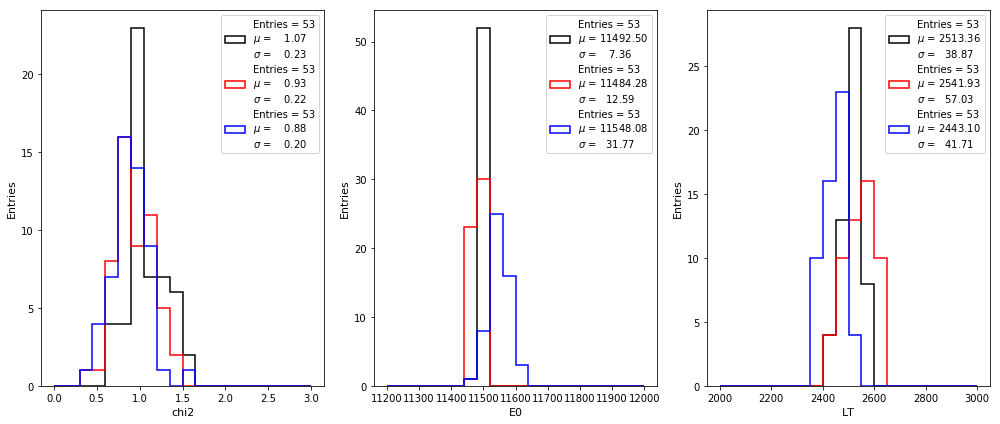

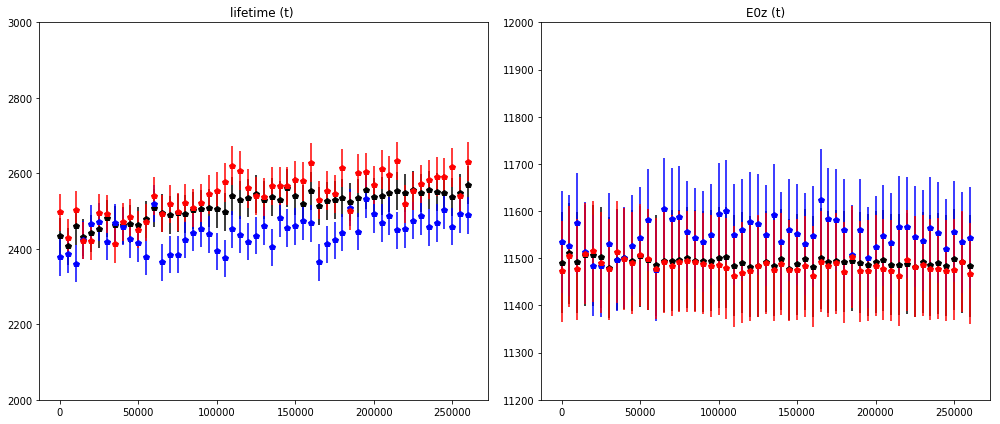

In [66]:
fbp = histo_fit_fb_pars(fp, fpf, fpb, range_e0 =(11200,12000))
plot_fit_fb_pars (fp, fpf, fpb,ltlim=(2000,3000), e0lim=(11200,12000))
print_fit_fb_pars(fbp)

#### E

In [67]:
fp, fpf, fpb = fb_fits(XT, DT, kcore, krNbins.Z, krNbins.S2e, 
                       range_z=(50,550), 
                       range_zf=(50,300), 
                       range_zb=(300,550), 
                       range_e = (7000, 12000),
                       energy = 'E', fit = FitType.profile)

chi2:  full  =     1.45  +-   0.29; front =     0.92 +-   0.19; back  =     0.98 +-   0.25;
e0  :  full  = 10071.33  +-   4.77; front = 10065.24 +-   6.10; back  = 10112.94 +-  16.05;
lt  :  full  =  2511.97  +-  39.90; front =  2538.41 +-  44.46; back  =  2450.28 +-  42.50;


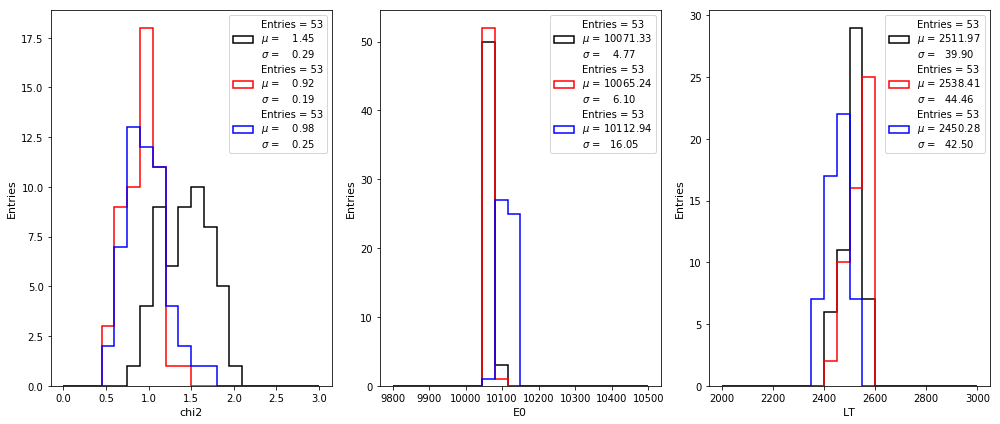

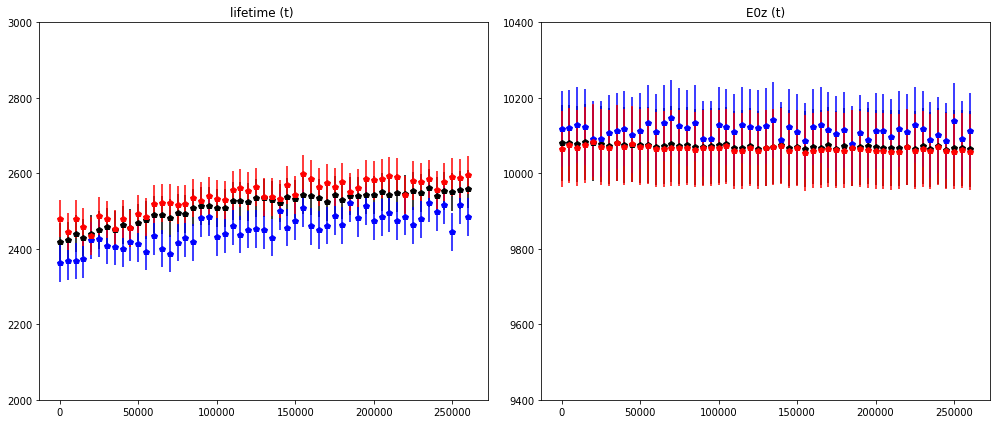

In [68]:
fbp = histo_fit_fb_pars(fp, fpf, fpb, range_e0 =(9800,10500))
plot_fit_fb_pars (fp, fpf, fpb,ltlim=(2000,3000), e0lim=(9400,10400))
print_fit_fb_pars(fbp)

#### Fits in core:

1. Using S2e chi2 of full fit is ~1, and thus no evidence of 2 LTs.
2. Using E, full fit chi2 is worse than f/b chi2s, showing either 2 LTs or a bias related with the normalization. Notice than E has been corrected by geometry but fits allow E0 to vary. 

### Fiducial

#### S2e

In [69]:
fp, fpf, fpb = fb_fits(XT, DT, kfid, krNbins.Z, krNbins.S2e, 
                       range_z=(50,550), 
                       range_zf=(50,300), 
                       range_zb=(300,550), 
                       range_e = (7000, 12000),
                       energy = 'S2e', fit = FitType.profile)

chi2:  full  =     1.12  +-   0.26; front =     1.07 +-   0.21; back  =     0.92 +-   0.21;
e0  :  full  = 11010.11  +-   8.47; front = 11010.21 +-  14.31; back  = 11067.56 +-  33.57;
lt  :  full  =  2439.76  +-  33.32; front =  2438.61 +-  57.28; back  =  2370.32 +-  39.36;


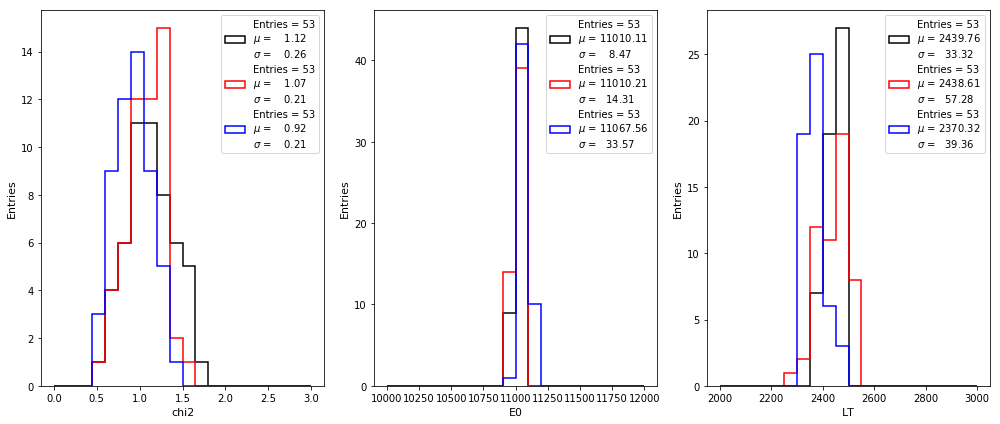

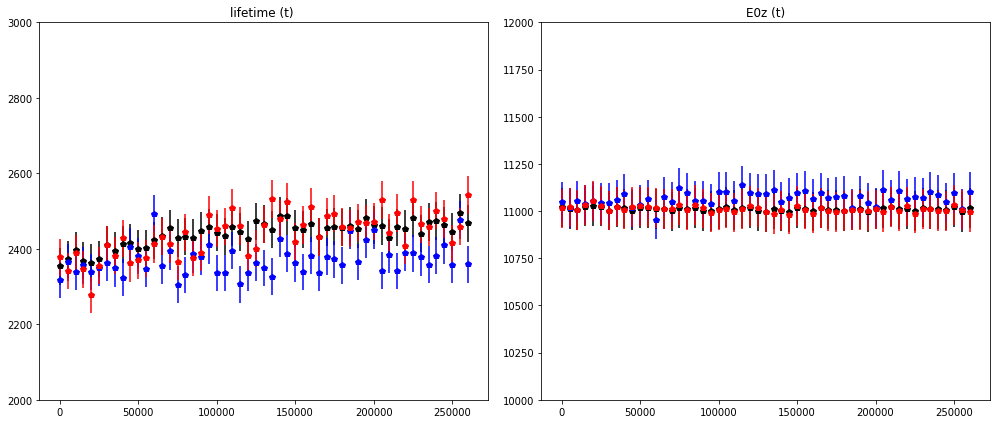

In [70]:
fbp = histo_fit_fb_pars(fp, fpf, fpb, range_e0 =(10000,12000))
plot_fit_fb_pars (fp, fpf, fpb,ltlim=(2000,3000), e0lim=(10000,12000))
print_fit_fb_pars(fbp)

#### E

In [71]:
fp, fpf, fpb = fb_fits(XT, DT, kfid, krNbins.Z, krNbins.S2e, 
                       range_z=(50,550), 
                       range_zf=(50,300), 
                       range_zb=(300,550), 
                       range_e = (7000, 12000),
                       energy = 'E', fit = FitType.profile)

chi2:  full  =     1.85  +-   0.35; front =     0.98 +-   0.24; back  =     1.04 +-   0.23;
e0  :  full  = 10070.58  +-   3.61; front = 10065.87 +-   4.85; back  = 10113.71 +-  10.78;
lt  :  full  =  2430.69  +-  32.28; front =  2451.26 +-  38.11; back  =  2370.31 +-  31.01;


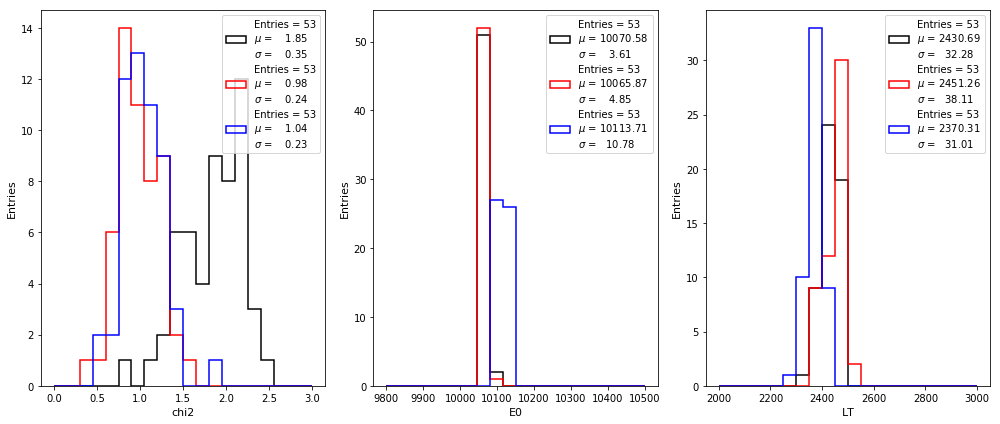

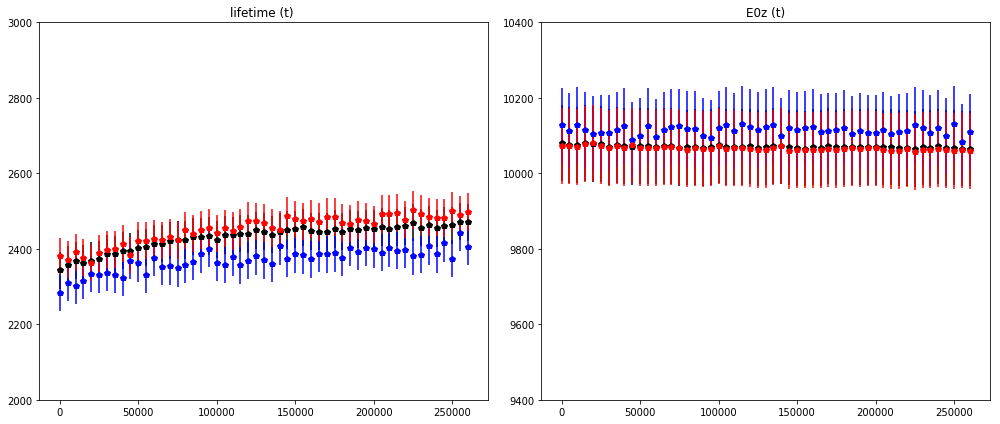

In [55]:
fbp = histo_fit_fb_pars(fp, fpf, fpb, range_e0 =(9800,10500))
plot_fit_fb_pars (fp, fpf, fpb,ltlim=(2000,3000), e0lim=(9400,10400))
print_fit_fb_pars(fbp)

#### Fits in fiducial:
1. S2e still compatible with a single LT
2. E fits to a single LT bad chi2, two apparent LT but also two apparent E0s, suggesting the possibility of a bias.

### Full

#### S2e

In [73]:
fp, fpf, fpb = fb_fits(XT, DT, kfull, krNbins.Z, krNbins.S2e, 
                       range_z=(50,550), 
                       range_zf=(50,300), 
                       range_zb=(300,550), 
                       range_e = (7000, 12000),
                       energy = 'S2e', fit = FitType.profile)

chi2:  full  =     1.21  +-   0.25; front =     1.21 +-   0.25; back  =     0.93 +-   0.20;
e0  :  full  = 10088.69  +-  10.20; front = 10109.59 +-  16.83; back  = 10127.06 +-  43.48;
lt  :  full  =  2684.17  +-  38.69; front =  2591.80 +-  67.06; back  =  2628.67 +-  74.24;


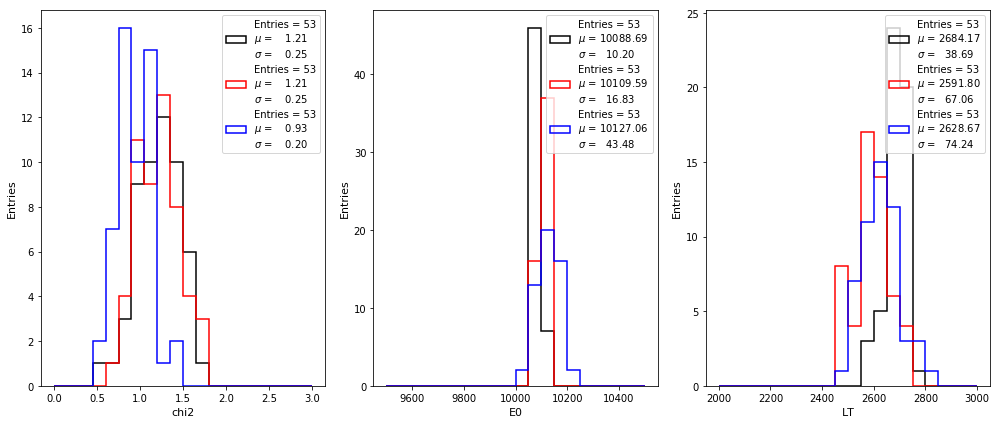

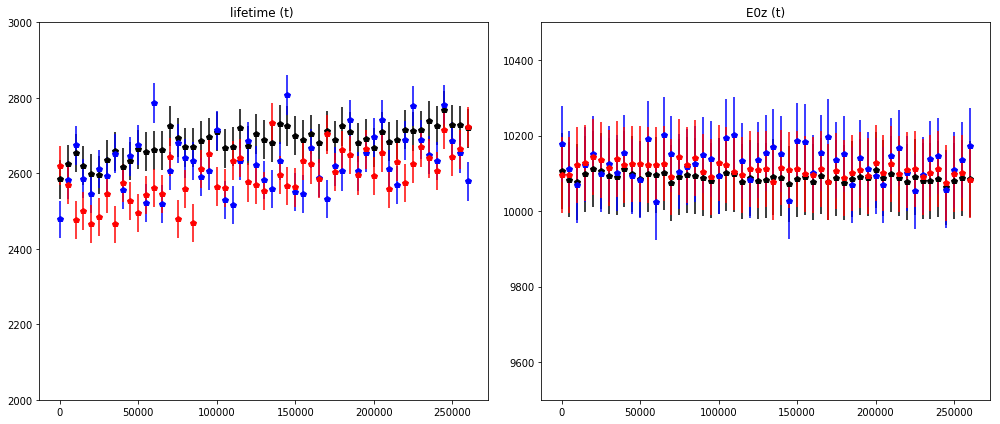

In [74]:
fbp = histo_fit_fb_pars(fp, fpf, fpb, range_e0 =(9500,10500))
plot_fit_fb_pars (fp, fpf, fpb,ltlim=(2000,3000), e0lim=(9500,10500))
print_fit_fb_pars(fbp)

#### E

In [75]:
fp, fpf, fpb = fb_fits(XT, DT, kfull, krNbins.Z, krNbins.S2e, 
                       range_z=(50,550), 
                       range_zf=(50,300), 
                       range_zb=(300,550), 
                       range_e = (7000, 12000),
                       energy = 'E', fit = FitType.profile)

chi2:  full  =     1.18  +-   0.25; front =     1.11 +-   0.26; back  =     1.00 +-   0.18;
e0  :  full  = 10057.95  +-   2.83; front = 10062.23 +-   3.64; back  = 10081.27 +-   9.58;
lt  :  full  =  2339.49  +-  27.60; front =  2327.68 +-  30.83; back  =  2309.31 +-  27.21;


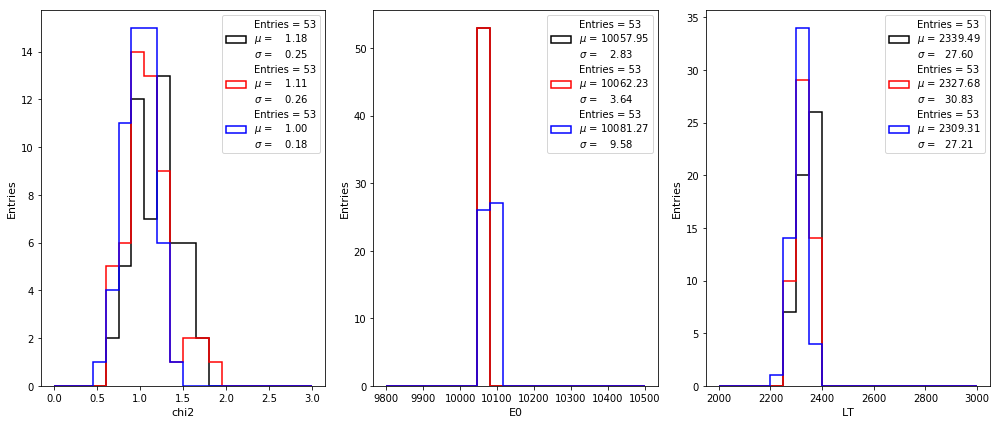

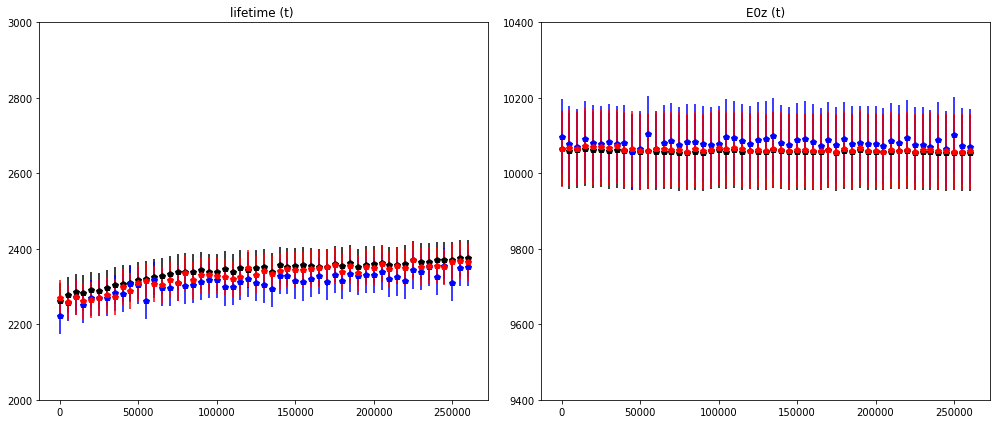

In [76]:
fbp = histo_fit_fb_pars(fp, fpf, fpb, range_e0 =(9800,10500))
plot_fit_fb_pars (fp, fpf, fpb,ltlim=(2000,3000), e0lim=(9400,10400))
print_fit_fb_pars(fbp)

#### Fits in full:
1. S2e trend is toward 2 LTs, although not convincing (chi2 values similar for full, f/b)
2. E in the full becomes more uniform and the evidence for 2 LTs dissappears. At the same time, the values of e0 for f/b become closer, **and the overall value of LT decreases significantly (by 300 mus) wrt S2e**. Why? 


### Do we have two LT?

1. The data does not appear to support 2 LT.
2. Fits to energy corrected (by geometry) can possibly bias the value of LT. **It seems necessary to fit S2e**.
3. Fits need to be divided in time bins, to take into account LT variation. 